In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from os import path
from linear_opt.lin_metabolism import LinearMetabolicModel

from SALib import ProblemSpec

In [2]:
model_dir = '../models/linear/respiration/'
m_fname = path.join(model_dir, 'glucose_resp_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_resp_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)

In [3]:
# Do a quick run of the model to make sure it is feasible
p = lam.max_anabolic_rate_problem(maint=1e-6, min_phi_o=0.1)
res = p.solve(verbose=True)
p.value

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jul 13 11:22:31 AM: Your problem has 5 variables, 3 constraints, and 18 parameters.
(CVXPY) Jul 13 11:22:31 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 13 11:22:31 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 13 11:22:31 AM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 13 11:22:31 AM: Reduction chain: EvalParams -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Jul 13 11:22:31 AM: Applying reduction EvalParams
(CVXPY) Jul 13 11:22:31 AM: Applying 

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


1.214999999475693

In [8]:
p = lam.max_anabolic_rate_problem(min_phi_o=0.4, max_lambda_hr=0.1)
lambdas = np.arange(0.1, 1.501, 0.01)
results = []

for lam_val in lambdas:
    p.param_dict['max_lambda_hr'].value = lam_val
    res = p.solve()
    d = lam.solution_as_dict(p)
    results.append(d)   

phi_df = pd.DataFrame(results)
phi_df['max_lambda_hr'] = lambdas
phi_df.set_index('lambda_hr', inplace=True)
phi_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,max_lambda_hr,phi_o,min_phi_o,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,ATP_homeostasis_phi,ATP_homeostasis_flux
lambda_hr,,,,,,,,,,,
0.10,0.10,0.494973,0.4,0.049067,0.000025,0.196269,0.000098,0.055556,0.000028,0.204135,0.000102
0.11,0.11,0.493922,0.4,0.048768,0.000024,0.195074,0.000098,0.061111,0.000031,0.201125,0.000101
0.12,0.12,0.492874,0.4,0.048469,0.000024,0.193878,0.000097,0.066667,0.000033,0.198113,0.000099
0.13,0.13,0.491827,0.4,0.048170,0.000024,0.192681,0.000096,0.072222,0.000036,0.195100,0.000098
0.14,0.14,0.490780,0.4,0.047871,0.000024,0.191484,0.000096,0.077778,0.000039,0.192086,0.000096


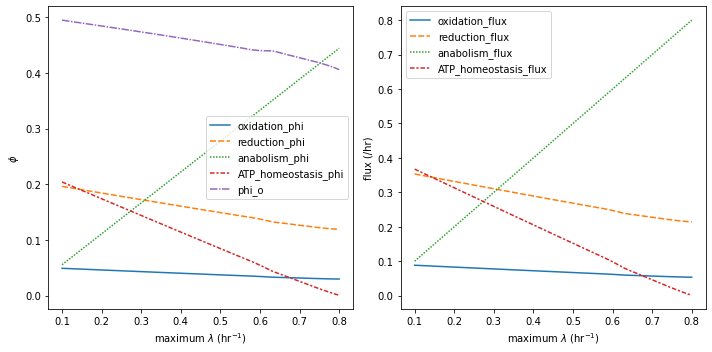

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
mask = (phi_df != 0).all(axis=1)

plt.sca(axs[0])

phi_cols = [c for c in phi_df.columns if c.endswith('phi')] + ['phi_o']
sns.lineplot(data=phi_df[mask][phi_cols])
plt.xlabel(r'maximum $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'$\phi$')   

plt.sca(axs[1])
j_cols = [c for c in phi_df.columns if c.endswith('flux')]
sns.lineplot(data=phi_df[mask][j_cols]*3600)
plt.xlabel(r'maximum $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'flux (/hr)')

plt.tight_layout()
plt.show()


In [16]:
# Use the SAlib tools to generate parameters for a sensitivity analysis
ps = ProblemSpec({
        "names": ["phi_o", "S6", "m_resp", "resp_ATP_per_e", "m_ATP_homeostasis"],
        "groups": None,
        "bounds": [[0.3, 0.5], [-0.5, 0.5], [10, 10000], [0.2, 2], [10, 10000],],
        "outputs": ["lambda_max"],
    })
ps.sample_sobol(64)

# Store the results in a dictionary for making a dataframe
res_dict = dict(ZCB=[], S6=[], phi_O=[], lambda_max=[], m_resp=[],
                resp_ATP_per_e=[], m_ATP_homeostasis=[])
for p in list(lam.processes) + ['other']:
    res_dict['{0}_phi'.format(p)] = []
    res_dict['{0}_flux'.format(p)] = []

for phi_o, s6, m_resp, atp_per_e, m_homeo in ps.samples:
    lam.set_S6(s6)
    lam.set_process_mass('reduction', m_resp)
    lam.set_process_mass('ATP_homeostasis', m_homeo)
    lam.set_ATP_yield('reduction', atp_per_e)
    max_lam, opt_prob = lam.maximize_lambda(phi_o=phi_o)

    res_dict['ZCB'].append(lam.ZCB)
    res_dict['S6'].append(s6)
    res_dict['phi_O'].append(phi_o)
    res_dict['m_resp'].append(m_resp)
    res_dict['resp_ATP_per_e'].append(atp_per_e)
    res_dict['m_ATP_homeostasis'].append(m_homeo)

    if max_lam == 0:
        res_dict['lambda_max'].append(0)
        for k, process in enumerate(lam.processes):
            res_dict['{0}_phi'.format(process)].append(np.NaN)
            res_dict['{0}_flux'.format(process)].append(np.NaN)
        res_dict['other_phi'].append(np.NaN)
        res_dict['other_flux'].append(np.NaN)
    else:
        res_dict['lambda_max'].append(max_lam)

        phis = opt_prob.var_dict['phis'].value.copy()
        js = 3600*phis*lam.kcat_s/lam.m_Da
        for k, process in enumerate(lam.processes):
            res_dict['{0}_phi'.format(process)].append(phis[k])
            res_dict['{0}_flux'.format(process)].append(js[k])
        res_dict['other_phi'].append(phis[-1])
        res_dict['other_flux'].append(np.NaN)

res_df = pd.DataFrame(res_dict)
res_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,ZCB,S6,phi_O,lambda_max,m_resp,resp_ATP_per_e,m_ATP_homeostasis,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,ATP_homeostasis_phi,ATP_homeostasis_flux,other_phi,other_flux
0,0.082181,-0.041090,0.428920,0.063008,4039.816944,0.697436,5203.319483,0.002582,0.004648,0.533493,0.023771,0.035005,0.063008,2.518665e-10,8.712892e-12,2.518665e-10,NaN
1,0.082181,-0.041090,0.445244,0.061207,4039.816944,0.697436,5203.319483,0.002508,0.004515,0.518243,0.023091,0.034004,0.061207,2.496542e-10,8.636364e-12,2.496542e-10,NaN
2,-0.064494,0.032247,0.428920,0.066556,4039.816944,0.697436,5203.319483,0.003877,0.006979,0.530227,0.023625,0.036975,0.066556,2.988617e-10,1.033861e-11,2.988617e-10,NaN
3,0.082181,-0.041090,0.428920,0.061479,4147.408142,0.697436,5203.319483,0.002520,0.004535,0.534406,0.023194,0.034155,0.061479,2.765759e-10,9.567673e-12,2.765759e-10,NaN
4,0.082181,-0.041090,0.428920,0.085432,4039.816944,1.016066,5203.319483,0.002251,0.004052,0.521367,0.023230,0.047462,0.085432,1.048563e-10,3.627325e-12,1.048563e-10,NaN


In [7]:
ps.set_results(res_df.lambda_max.values)
ps.analyze_sobol(print_to_console=True, calc_second_order=True)

                         ST   ST_conf
phi_o              0.013175  0.007593
S6                 0.534412  0.359390
m_resp             0.316862  0.287564
resp_ATP_per_e     0.092216  0.083408
m_ATP_homeostasis  0.001270  0.001928
                         S1   S1_conf
phi_o             -0.065177  0.083765
S6                -0.151378  0.610066
m_resp             0.336033  0.297473
resp_ATP_per_e    -0.031032  0.102816
m_ATP_homeostasis  0.001496  0.011320
                                           S2   S2_conf
(phi_o, S6)                          0.098255  0.093115
(phi_o, m_resp)                      0.166164  0.179954
(phi_o, resp_ATP_per_e)              0.138428  0.158720
(phi_o, m_ATP_homeostasis)           0.156792  0.166780
(S6, m_resp)                         0.242069  0.499512
(S6, resp_ATP_per_e)                 0.309119  0.439081
(S6, m_ATP_homeostasis)              0.256408  0.477372
(m_resp, resp_ATP_per_e)            -0.140570  0.426388
(m_resp, m_ATP_homeostasis)         -0.1

{'names': ['phi_o', 'S6', 'm_resp', 'resp_ATP_per_e', 'm_ATP_homeostasis'],
 'groups': None,
 'bounds': [[0.3, 0.5], [-0.5, 0.5], [10, 10000], [0.2, 2], [10, 10000]],
 'outputs': ['lambda_max'],
 'num_vars': 5,
 'sample_scaled': True}

<AxesSubplot: xlabel='m_resp', ylabel='lambda_max'>

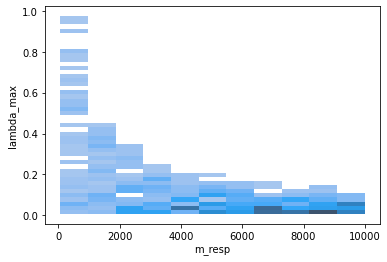

In [8]:
sns.histplot(data=res_df, y='lambda_max', x='m_resp', legend=False)

In [9]:
mask = np.logical_and(res_df.lambda_max > 0.01, res_df.m_ATP_homeostasis > 500)
cols = 'ZCB,S6,phi_O,m_resp,resp_ATP_per_e,m_ATP_homeostasis,lambda_max,anabolism_phi'.split(',')
res_df[mask][cols].sort_values('lambda_max', ascending=False)

,ZCB,S6,phi_O,m_resp,resp_ATP_per_e,m_ATP_homeostasis,lambda_max,anabolism_phi
387,-0.353166,0.176583,0.324522,61.819722,1.260779,9961.339787,0.973791,0.540995
384,-0.353166,0.176583,0.324522,108.638471,1.260779,9961.339787,0.910740,0.505966
388,-0.353166,0.176583,0.324522,108.638471,0.661951,9961.339787,0.798449,0.443583
394,0.285007,-0.142503,0.426605,61.819722,0.661951,9961.339787,0.794528,0.441404
385,-0.353166,0.176583,0.426605,108.638471,1.260779,9961.339787,0.773102,0.429501
...,...,...,...,...,...,...,...,...
442,0.878832,-0.439416,0.407357,7432.302948,1.174676,5023.942468,0.010346,0.005748
441,0.878832,-0.439416,0.407357,7432.302948,0.781502,9850.068566,0.010216,0.005676
222,0.271419,-0.135710,0.470924,9519.297059,0.217662,7436.344270,0.010137,0.005632
421,0.821407,-0.410703,0.487218,7150.753753,0.925443,6832.905306,0.010123,0.005624


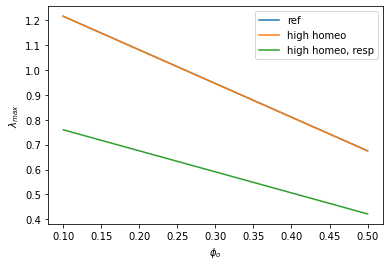

In [22]:
ref_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)

high_homeo_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
high_homeo_lam.set_process_mass('ATP_homeostasis', 400) # 4x baseline

high_homeo_resp_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
high_homeo_resp_lam.set_process_mass('ATP_homeostasis', 400) # 4x baseline
high_homeo_resp_lam.set_process_mass('reduction', 400) # 4x baseline

phi_os = np.arange(0.1, 0.501, 0.1)
maint = 0.0
ref_lambdas = [ref_lam.maximize_lambda(phi_o=p, maint=maint)[0] for p in phi_os]
high_homeo_lambdas = [high_homeo_lam.maximize_lambda(phi_o=p, maint=maint)[0] for p in phi_os]
high_homeo_resp_lambdas = [high_homeo_resp_lam.maximize_lambda(phi_o=p, maint=maint)[0] for p in phi_os]

plt.plot(phi_os, ref_lambdas, label='ref')
plt.plot(phi_os, high_homeo_lambdas, label='high homeo')
plt.plot(phi_os, high_homeo_resp_lambdas, label='high homeo, resp')
plt.legend()
plt.xlabel(r'$\phi_o$')
plt.ylabel(r'$\lambda_{max}$')
plt.show()

In [11]:
ZCBs = np.arange(-1, 1.01, 0.05)
phi_os = np.arange(0.1, 0.501, 0.2)
homeo_costs = np.logspace(1, 3, 3)
resp_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

ref_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
res_dict = dict(ZCB=[], phi_o=[], homeo_cost=[], lambda_max=[], S6=[], resp_cost=[], resp_ATP_per_e=[])

for z in ZCBs:
    ref_lam.set_ZCB(z)
    for phi_o in phi_os:
        for homeo_cost in homeo_costs:
            for resp_cost in resp_costs:
                for atp_per_e in ATP_per_es:
                    ref_lam.set_process_mass('reduction', resp_cost)
                    ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                    ref_lam.set_ATP_yield('reduction', atp_per_e)
                    m, _ = ref_lam.maximize_lambda(phi_o=phi_o)
                    res_dict['ZCB'].append(z)
                    res_dict['phi_o'].append(phi_o)
                    res_dict['homeo_cost'].append(homeo_cost)
                    res_dict['lambda_max'].append(m)
                    res_dict['S6'].append(ref_lam.get_S6())
                    res_dict['resp_cost'].append(resp_cost)
                    res_dict['resp_ATP_per_e'].append(atp_per_e)
res_df = pd.DataFrame(res_dict)

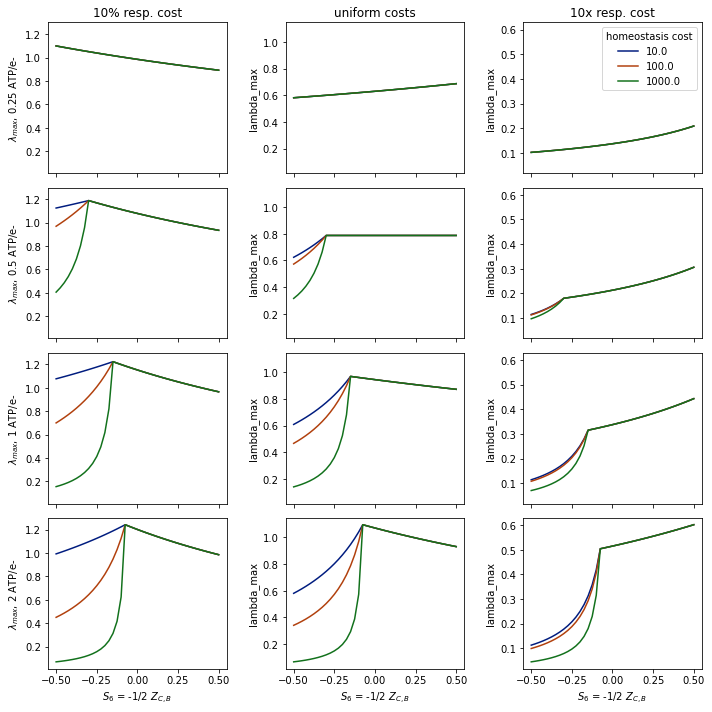

In [12]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey='col')

titles = '10% resp. cost,uniform costs,10x resp. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.resp_cost == resp_cost, res_df.phi_o == phi_os[1])
        mask = np.logical_and(mask, res_df.resp_ATP_per_e == a_per_e)
        sns.lineplot(data=res_df[mask], x='S6', y='lambda_max', hue='homeo_cost', palette='dark')
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\lambda_{{max}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend(title='homeostasis cost').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()